<a href="https://colab.research.google.com/github/yiwenzcmu/CryptoGPT/blob/LSTM/LSTM_Crypto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError, MeanAbsolutePercentageError
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler


In [66]:
file_path = '/content/drive/My Drive/CMU10623/Team Project/BTC-USD.csv'

# Read the CSV file directly using its full path
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to confirm it's loaded correctly
print(df.head())

         Date          Open          High           Low         Close  \
0  2018-01-01  14112.200195  14112.200195  13154.700195  13657.200195   
1  2018-01-02  13625.000000  15444.599609  13163.599609  14982.099609   
2  2018-01-03  14978.200195  15572.799805  14844.500000  15201.000000   
3  2018-01-04  15270.700195  15739.700195  14522.200195  15599.200195   
4  2018-01-05  15477.200195  17705.199219  15202.799805  17429.500000   

      Adj Close       Volume  
0  13657.200195  10291200000  
1  14982.099609  16846600192  
2  15201.000000  16871900160  
3  15599.200195  21783199744  
4  17429.500000  23840899072  


In [67]:
missing_values_count = df.isna().sum()
print(missing_values_count)

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [68]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
# Define your date ranges
train_start, train_end = '2018-01-01', '2021-12-31'
test_start, test_end = '2022-01-01', '2023-01-01'
# Split the data
train_data = df.loc[train_start:train_end]
test_data = df.loc[test_start:test_end]

In [72]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['Open', 'High', 'Low', 'Close']])
test_scaled = scaler.transform(test_data[['Open', 'High', 'Low', 'Close']])

In [75]:
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

In [76]:
def create_dataset(dataset, look_back):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0:4]  # Features: Open, High, Low, Close
        X.append(a)
        Y.append(dataset[i + look_back, 3])  # Target: Next day Close
    return np.array(X), np.array(Y)

In [90]:
# def weighted_rmse_mape_loss(y_true, y_pred, alpha=0.5, beta=0.5):
#     # Ensure alpha + beta = 1
#     assert alpha + beta == 1, "The sum of alpha and beta should be 1"

#     # RMSE Component
#     mse = MeanSquaredError()
#     rmse = tf.sqrt(mse(y_true, y_pred))

#     # MAPE Component
#     mape = MeanAbsolutePercentageError()
#     mape_loss = mape(y_true, y_pred)

#     # Weighted Sum of RMSE and MAPE
#     return alpha * rmse + beta * mape_loss


In [105]:
def create_model_dropout(input_shape, units=100, dropout_rate=0.2):
    model = Sequential([
        LSTM(units, activation='tanh', recurrent_activation='sigmoid', return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(units, activation='tanh', recurrent_activation='sigmoid'),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
    return model

In [106]:
def step_decay(epoch):
    initial_lr = 0.01  # Starting learning rate
    drop = 0.5  # Reduce learning rate by half
    epochs_drop = 10.0  # Reduce every 10 epochs
    lr = initial_lr * (drop ** np.floor((1+epoch)/epochs_drop))
    return lr

In [109]:
lr_scheduler = LearningRateScheduler(step_decay)

In [110]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=120):
    history = model.fit(
        X_train, y_train, epochs=epochs, batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[lr_scheduler],
        verbose=1
    )
    return model, history

In [111]:
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = calculate_mape(y_true, y_pred)
    return rmse, mape

In [112]:
# Set look-back periods
look_back_values = [30]
results = []

for look_back in look_back_values:
    X_train, y_train = create_dataset(train_scaled, look_back)
    X_test, y_test = create_dataset(test_scaled, look_back)

    # Define the model
    model = create_model_dropout(input_shape=(X_train.shape[1], X_train.shape[2]), units=150, dropout_rate=0.2)

    # Train the model
    model, history = train_model(model, X_train, y_train, X_test, y_test)

    # Predict using the model
    predicted_prices = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(np.column_stack((np.zeros((len(predicted_prices),3)), predicted_prices)))[:,3]

    actual_prices = scaler.inverse_transform(np.column_stack((np.zeros((len(y_test),3)), y_test)))[:,3]

    # Evaluate the model
    rmse, mape = evaluate_model(actual_prices, predicted_prices)
    results.append((look_back, rmse, mape))

Epoch 1/50
12/12 [==============================] - 9s 357ms/step - loss: 0.3603 - val_loss: 0.0043 - lr: 0.0100
Epoch 2/50
12/12 [==============================] - 3s 221ms/step - loss: 0.0096 - val_loss: 0.0015 - lr: 0.0100
Epoch 3/50
12/12 [==============================] - 3s 227ms/step - loss: 0.0043 - val_loss: 0.0011 - lr: 0.0100
Epoch 4/50
12/12 [==============================] - 3s 238ms/step - loss: 0.0031 - val_loss: 9.6672e-04 - lr: 0.0100
Epoch 5/50
12/12 [==============================] - 4s 356ms/step - loss: 0.0023 - val_loss: 0.0014 - lr: 0.0100
Epoch 6/50
12/12 [==============================] - 3s 222ms/step - loss: 0.0020 - val_loss: 0.0014 - lr: 0.0100
Epoch 7/50
12/12 [==============================] - 3s 225ms/step - loss: 0.0019 - val_loss: 9.9541e-04 - lr: 0.0100
Epoch 8/50
12/12 [==============================] - 3s 225ms/step - loss: 0.0017 - val_loss: 9.4635e-04 - lr: 0.0100
Epoch 9/50
12/12 [==============================] - 3s 285ms/step - loss: 0.0016 - v

In [82]:
# Print the results for each look-back configuration
for result in results:
    print(f"Look-back: {result[0]}, RMSE: {result[1]:.3f}, MAPE: {result[2]:.2f}%")

Look-back: 5, RMSE: 1608.175, MAPE: 3.77%
Look-back: 10, RMSE: 2471.469, MAPE: 7.22%
Look-back: 20, RMSE: 2210.498, MAPE: 6.09%
Look-back: 30, RMSE: 1545.627, MAPE: 3.80%


In [113]:
for result in results:
  print(f"Look-back: {result[0]}, RMSE: {result[1]:.3f}, MAPE: {result[2]:.2f}%")

Look-back: 30, RMSE: 1705.038, MAPE: 4.48%


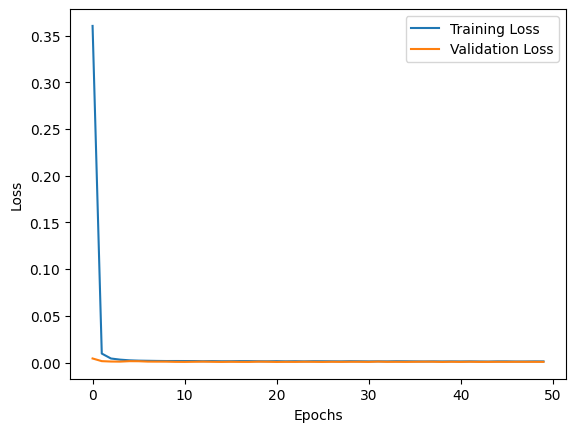

In [114]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

11/11 [==============================] - 0s 33ms/step


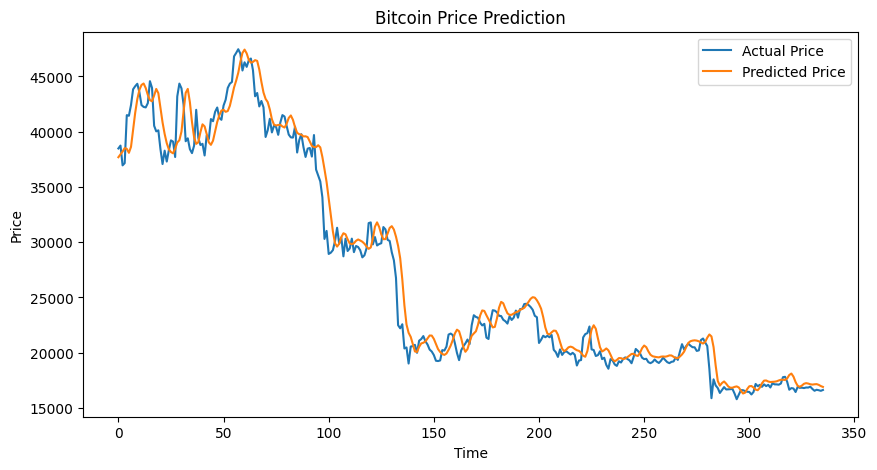

In [115]:
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(np.column_stack((np.zeros((len(predicted_prices),3)), predicted_prices)))[:,3]

# Actual prices
actual_prices = scaler.inverse_transform(np.column_stack((np.zeros((len(y_test),3)), y_test)))[:,3]

plt.figure(figsize=(10,5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [62]:
train_scaled

array([[0.16910808, 0.16541169, 0.15767174, 0.16198395],
       [0.16153268, 0.18574924, 0.15781257, 0.18257929],
       [0.18257338, 0.18770607, 0.18441299, 0.18598206],
       ...,
       [0.69017585, 0.6844979 , 0.68064054, 0.67166026],
       [0.67255487, 0.68083797, 0.6784063 , 0.68306106],
       [0.6831089 , 0.68988276, 0.67460259, 0.66951095]])

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(dates, actual_prices, label='Actual Prices')
plt.plot(dates[len(train_data):], predicted_prices, label='Predicted Prices', linestyle='--')
plt.title('Actual and Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

NameError: name 'dates' is not defined

<Figure size 1000x500 with 0 Axes>